In [1]:
# pip install mediapipe

## Importing libraries

In [25]:
import os
import cv2
import json
import pandas as pd
import mediapipe as mp
from random import sample
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tqdm import tqdm

## Basic functions

In [3]:
base_dir = './dataset'
image_dir = base_dir + '/image/'
annos_dir = base_dir + '/annos/'

files = os.listdir(image_dir)
annos = os.listdir(annos_dir)

In [4]:
# initializing blaze pose model 
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
mp_holistic = mp.solutions.holistic

In [14]:
def is_full_shot(results):
    """
    If an image contains nose, left ankle and right ankle, it might be a full shot.

    Threshold is set at 0.6

    Eg -> If model thinks there is 20% chance that all nose, left and right ankle are
    present we will mark that image as full shot.
    """
    right_ankle = results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_ANKLE]
    left_ankle = results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_ANKLE]
    nose = results.pose_landmarks.landmark[mp_holistic.PoseLandmark.NOSE]

    if right_ankle.visibility > 0.6 and left_ankle.visibility > 0.6 and nose.visibility > 0.6:
        return True
    else:
        return False

In [6]:
def relevant_info(data):
  """
    The json data contains many irrelevant infomation such as zoom_in, occulsion, viewpoint, etc.

    This function will extract relevant information and return it in form of a dictionory.

    Relevant Information includes bounding, category_id and category_name.
    """
  dictionary = dict()
  for key in data.keys():
      if 'item' in key:
          dictionary[key] = {'bounding_box': data[key]['bounding_box'],
                             'category_id': data[key]['category_id'],
                             'category_name': data[key]['category_name']}
  return dictionary


In [7]:
# updating Json
for ann in annos:
    with open(annos_dir + ann, 'r') as file:
        data = json.load(file)
        data = relevant_info(data)
    
    with open(annos_dir + ann, 'w') as file:
        json.dump(data, file, indent=4)

print('All annotation files updates!')

All annotation files updates!


## Pose Detection

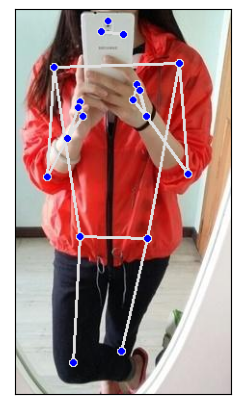

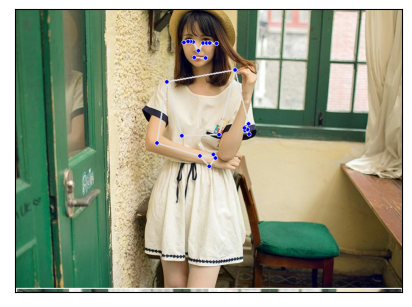

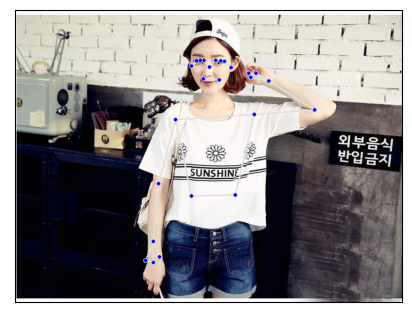

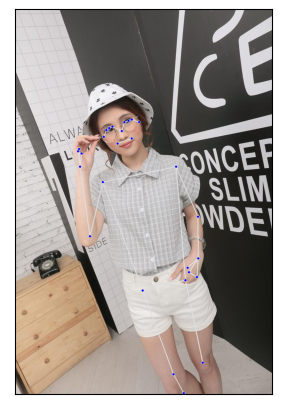

In [12]:
# Applying pose detection to a random selection of 10 images from image directory

num_images_to_process = 10
min_detection_confidence = 0.6

# Load the pose detection model
with mp_pose.Pose(static_image_mode=True, min_detection_confidence = min_detection_confidence) as pose:

    # Select random images to process
    random_files = sample(files, num_images_to_process)

    # Process each image
    for image_file in random_files:
        image = mpimg.imread(os.path.join(image_dir, image_file))

        # Run the pose detection model on the image
        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # Skip images where no pose was detected
        if results.pose_landmarks is None:
            continue

        # Draw the pose landmarks on the image
        annotated_image = image.copy()
        mp_drawing.draw_landmarks(
            annotated_image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        # Display the annotated image
        plt.figure(figsize=(5, 5))
        plt.xticks([])
        plt.yticks([])
        plt.imshow(annotated_image)
        plt.show()


## Full shot images

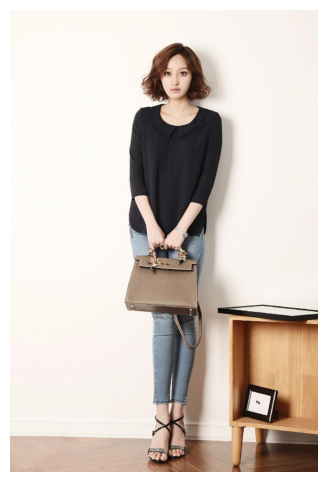

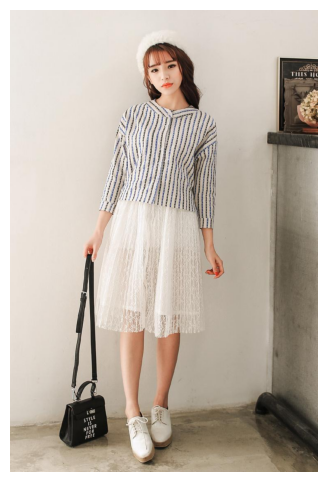

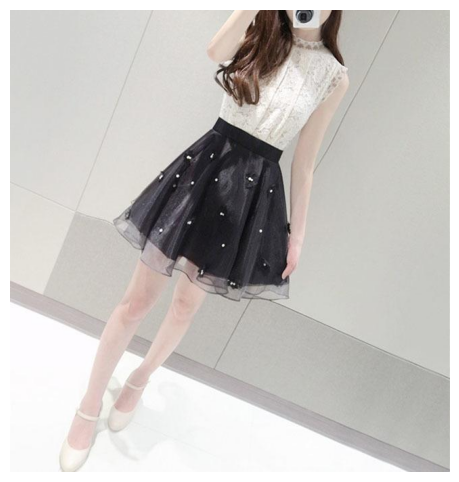

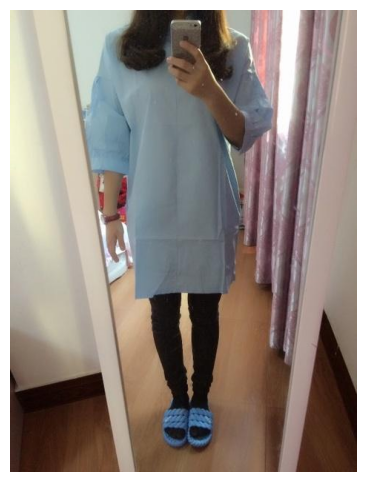

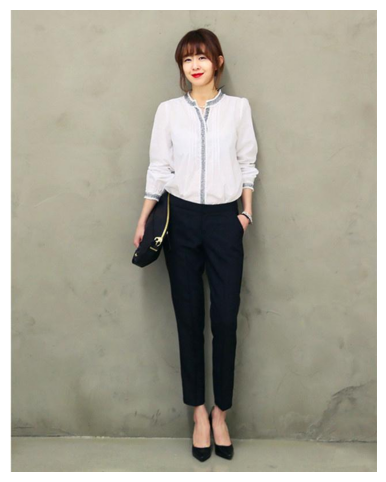

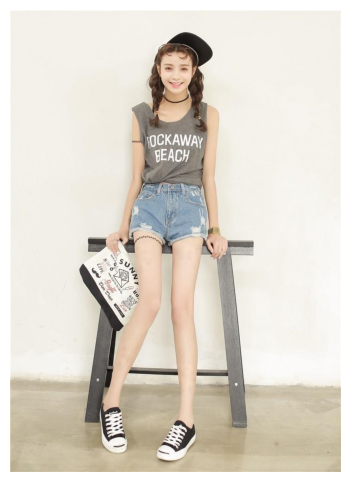

In [17]:
# Randomly select 15 files
random_files = sample(files, 15)

# Load pose detection model
with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5) as pose:
    # Loop through each file
    for file in random_files:
        # Read image file
        image = mpimg.imread(os.path.join(image_dir, file))

        # Process image with pose detection model
        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # Check if pose detection was successful
        if results.pose_landmarks is None:
            # Ignore images where pose detection failed
            continue

        # Check if the pose detected in the image is a full shot
        if is_full_shot(results):
            # Display image if it is a full shot
            plt.figure(figsize=(6, 6))
            plt.axis("off")
            plt.imshow(image)
            plt.show()

## Non full shot images

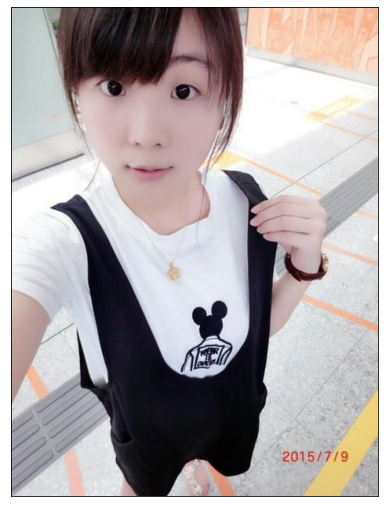

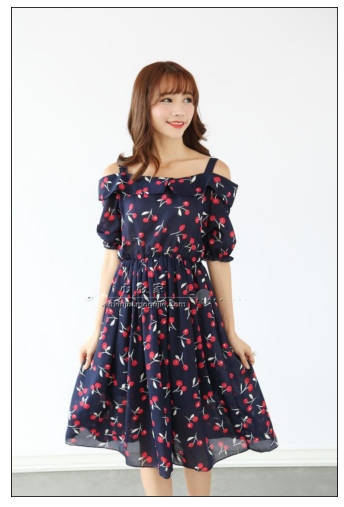

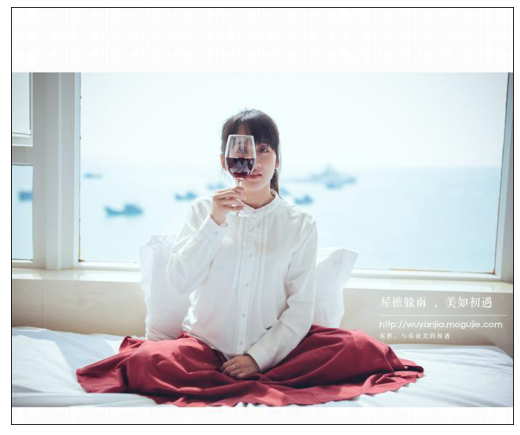

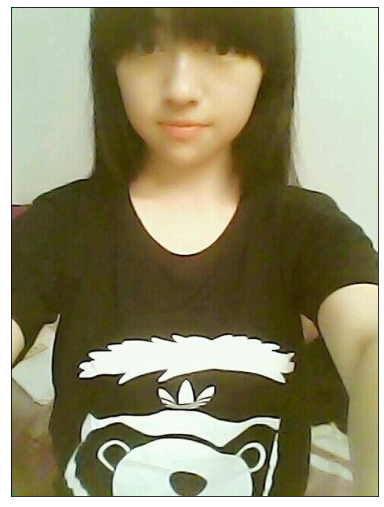

In [ ]:
# Randomly select 15 files
random_files = sample(files, 15)

# Load pose detection model
with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5) as pose:
    # Loop through each file
    for file in random_files:
        if not os.path.exists(image_dir + file):
            continue
        # Read image file
        image = mpimg.imread(os.path.join(image_dir, file))

        # Process image with pose detection model
        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # Check if pose detection was successful
        if results.pose_landmarks is None:
            # Ignore images where pose detection failed
            continue

        # Check if the pose detected in the image is not a full shot
        if not is_full_shot(results):
            # Display image if it is not a full shot
            plt.figure(figsize=(6, 6))
            plt.axis("off")
            plt.imshow(image)
            plt.show()

## Full shot detection on whole DeepFashion2 dataset

In [26]:
# Create an empty list to store information about full-shot images
full_shot_images = []

# Load the pose detection model
with mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5) as pose:
    # Loop over all image files
    for file in tqdm(files):
        # Read the image file
        image = mpimg.imread(image_dir + file)

        # Process the image with the pose detection model
        results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # If no pose landmarks are detected, delete the image file and its annotation file
        if results.pose_landmarks is None:
            os.remove(image_dir + file)
            os.remove(annos_dir + file.split('.')[0] + '.json')
            continue

        # If the image does not have a full pose, delete the image file and its annotation file
        if not is_full_shot(results):
            os.remove(image_dir + file)
            os.remove(annos_dir + file.split('.')[0] + '.json')
            continue

        # Store information about the full-shot image in the list
        image_height, image_width, _ = image.shape
        full_shot_images.append({'id': file, 'height': image_height, 'width': image_width})

# Convert the list of full-shot image information to a pandas dataframe
full_shot_df = pd.DataFrame(full_shot_images)

# Print the head of the dataframe
print(full_shot_df.head(8))

100%|██████████| 191961/191961 [2:17:31<00:00, 23.26it/s]  


           id  height  width
0  000011.jpg     961    750
1  000018.jpg     949    750
2  000024.jpg     401    640
3  000027.jpg     653    640
4  000031.jpg     415    640
5  000032.jpg     671    640
6  000054.jpg    1000    750
7  000055.jpg    1000    750


In [28]:
full_shot_df.to_csv('full-shot-dataset.csv')